In [1]:
# %matplotlib inline
# !pip install deeptrack

# Example X. Image segmentation

## 1. Setup

Imports and defines the objects needed for this example.

In [2]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import itertools
import glob
from deeptrack.extras import datasets
from tensorflow.keras import layers

import deeptrack as dt

datasets.load("MitoGAN")
PATH_TO_DATASET = "./datasets/MitoGAN/"

TRAINING_ROOT = PATH_TO_DATASET + 'train/'
VALIDATION_ROOT = PATH_TO_DATASET + 'validation/'

TRAINING_PATHS =  sorted(glob.glob(TRAINING_ROOT + "*"))
VALIDATION_PATHS =  sorted(glob.glob(VALIDATION_ROOT + "*"))

number_of_training_files = len([file for file in TRAINING_PATHS if "membranes_" in file])
number_of_validation_files = len([file for file in VALIDATION_PATHS if "membranes_" in file])

c:\GU\DeepTrack-2.0\deeptrack\backend\_config.py:11: UserWarning: cupy not installed. GPU-accelerated simulations will not be possible
  warnings.warn(
c:\GU\DeepTrack-2.0\deeptrack\backend\_config.py:25: UserWarning: cupy not installed, CPU acceleration not enabled
  warnings.warn("cupy not installed, CPU acceleration not enabled")


Dataset already downloaded.


## 2. Defining the dataset

In [3]:
load_string_struct = "{0}{1}*.png"

get_training_images = dt.LoadImage(
    path=glob.glob(
        load_string_struct.format(TRAINING_ROOT, "raw_"),
    )
)

get_training_mask_membranes = dt.LoadImage(
    path=glob.glob(
        load_string_struct.format(TRAINING_ROOT, "membranes_"),
    )
)
get_training_mask_mitochondria = dt.LoadImage(
    path=glob.glob(
        load_string_struct.format(TRAINING_ROOT, "mitochondria_"),
    )
)

# We combine the masks of membranes and mitochondria into a single mask.
get_training_mask = (2 / 255) * get_training_mask_membranes + (
    get_training_mask_mitochondria > 0.0
) * 1.0


The training images are normalized between 0 and 1

In [4]:
normalization = dt.NormalizeMinMax(0, 1)

get_training_images >>= normalization

We explicitly load the images

In [30]:
training_images = get_training_images.resolve()[..., np.newaxis]
training_labels = get_training_mask.resolve()[..., np.newaxis]

training_labels = np.clip(training_labels, 0, 2)

In [31]:
training_images = np.transpose(training_images, ((2, 0, 1, 3)))
training_labels = np.transpose(training_labels, ((2, 0, 1, 3)))

### 3. Visualizing the training data

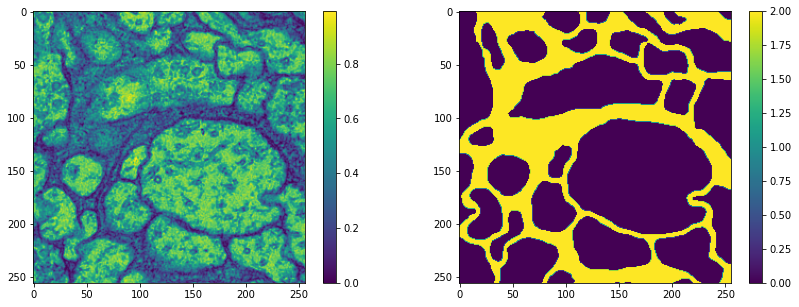

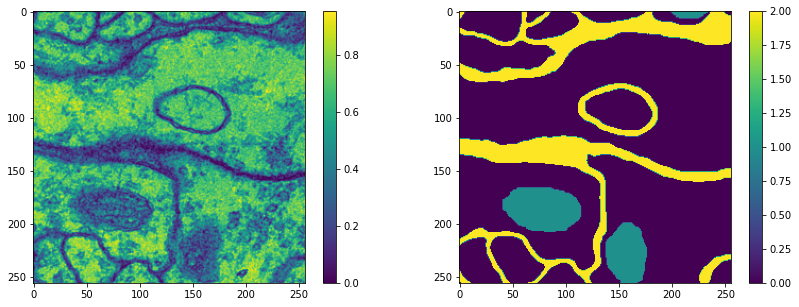

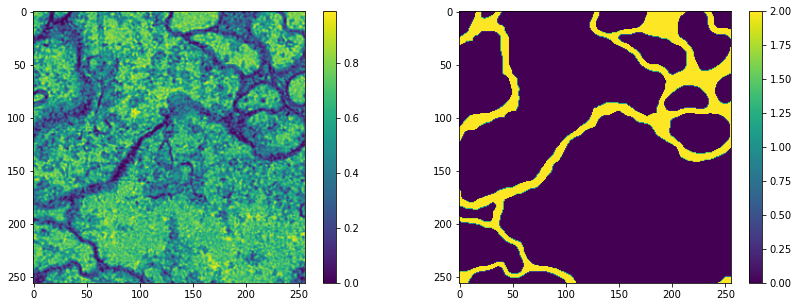

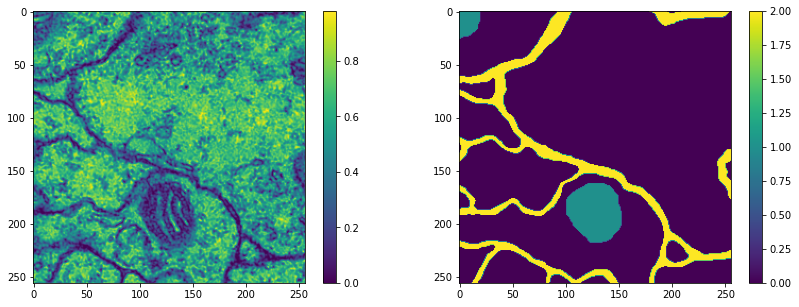

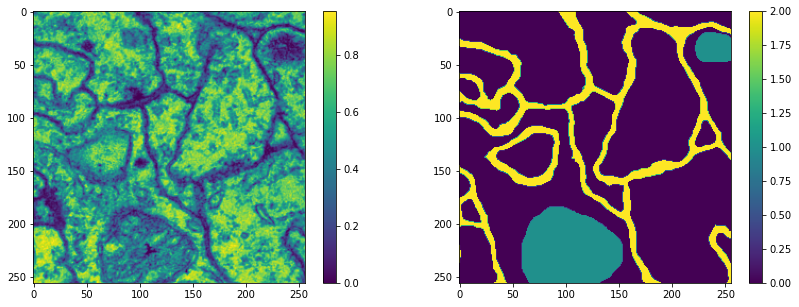

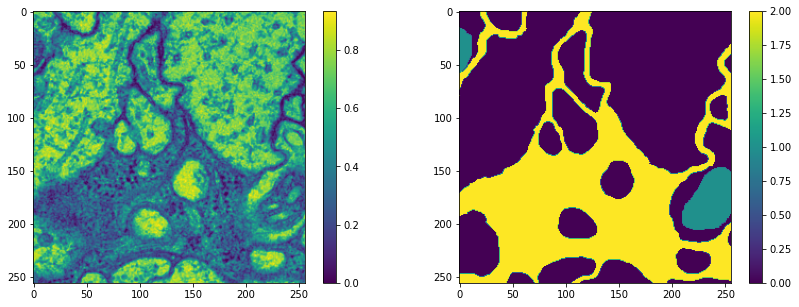

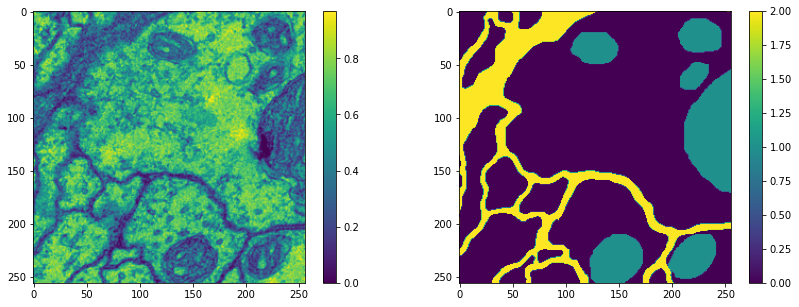

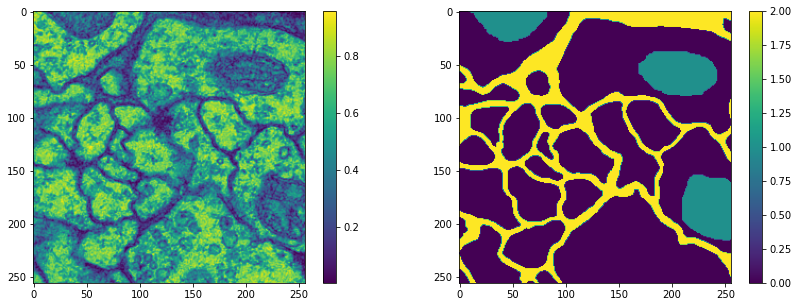

In [42]:
import tensorflow.keras.utils as utils

NUMBER_OF_IMAGES = 8
for _ in range(NUMBER_OF_IMAGES):
    idx = np.random.randint(0, training_images.shape[0])

    image = training_images[idx, ..., 0]
    mask = training_labels[idx, ..., 0]
    
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.colorbar()
    plt.show()

## 4. Defining the model

In [46]:
import tensorflow as tf

model = dt.models.unet(
    number_of_outputs=3,
    output_activation="softmax",
).model
model.summary()

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer="adam",
    metrics=["accuracy"],
)

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, None, None, 1 160         input_4[0][0]                    
__________________________________________________________________________________________________
activation_36 (Activation)      (None, None, None, 1 0           conv2d_39[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, None, None, 1 0           activation_36[0][0]              
_______________________________________________________________________________________

## 5. Training the network

In [47]:
TRAIN_MODEL = True

if TRAIN_MODEL:
    model.fit(
        training_images,
        training_labels,
        epochs=50,
        batch_size=8,
    )

    #model.save("model.h5")
else:
    path = datasets.load_model("")
    model.load_weights(path)

Epoch 1/50
111/111 [==============================] - 7s 62ms/step - loss: 0.4865 - accuracy: 0.8134
Epoch 2/50
111/111 [==============================] - 7s 64ms/step - loss: 0.3785 - accuracy: 0.8592
Epoch 3/50
111/111 [==============================] - 10s 93ms/step - loss: 0.3264 - accuracy: 0.8705
Epoch 4/50
111/111 [==============================] - 7s 63ms/step - loss: 0.2802 - accuracy: 0.8881
Epoch 5/50
111/111 [==============================] - 7s 64ms/step - loss: 0.2042 - accuracy: 0.9201
Epoch 6/50
111/111 [==============================] - 7s 66ms/step - loss: 0.1617 - accuracy: 0.9360
Epoch 7/50
111/111 [==============================] - 7s 66ms/step - loss: 0.1425 - accuracy: 0.9426
Epoch 8/50
111/111 [==============================] - 7s 66ms/step - loss: 0.1288 - accuracy: 0.9475
Epoch 9/50
111/111 [==============================] - 7s 64ms/step - loss: 0.1233 - accuracy: 0.9493
Epoch 10/50
111/111 [==============================] - 9s 78ms/step - loss: 0.1127 - accur

## 5. Validating the network

### 5.1 Loading validation data

In [49]:
get_validation_images = dt.LoadImage(
    path=glob.glob(
        load_string_struct.format(VALIDATION_ROOT, "raw_"),
    )
) >> normalization

get_validation_mask_membranes = dt.LoadImage(
    path=glob.glob(
        load_string_struct.format(VALIDATION_ROOT, "membranes_"),
    )
)
get_validation_mask_mitochondria = dt.LoadImage(
    path=glob.glob(
        load_string_struct.format(VALIDATION_ROOT, "mitochondria_"),
    )
)

# We combine the masks of membranes and mitochondria into a single mask.
get_validation_mask = (2 / 255) * get_validation_mask_membranes + (
    get_validation_mask_mitochondria > 0.0
) * 1.0


In [51]:
validation_images = get_validation_images.resolve()[..., np.newaxis]
validation_labels = get_validation_mask.resolve()[..., np.newaxis]

validation_labels = np.clip(validation_labels, 0, 2)

In [53]:
validation_images = np.transpose(validation_images, ((2, 0, 1, 3)))
validation_labels = np.transpose(validation_labels, ((2, 0, 1, 3)))

### 5.2 Visualizing results

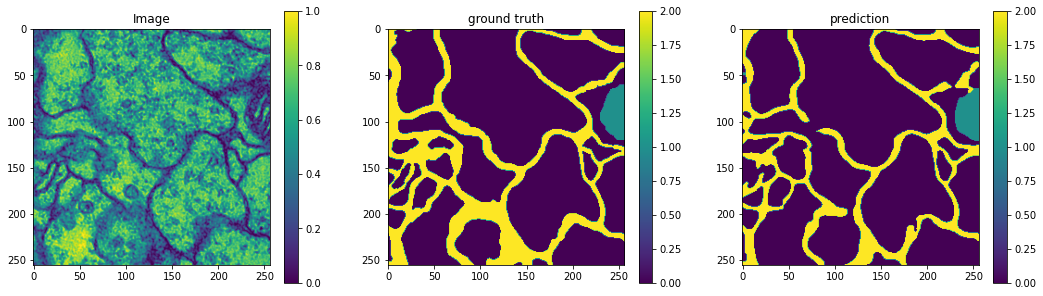

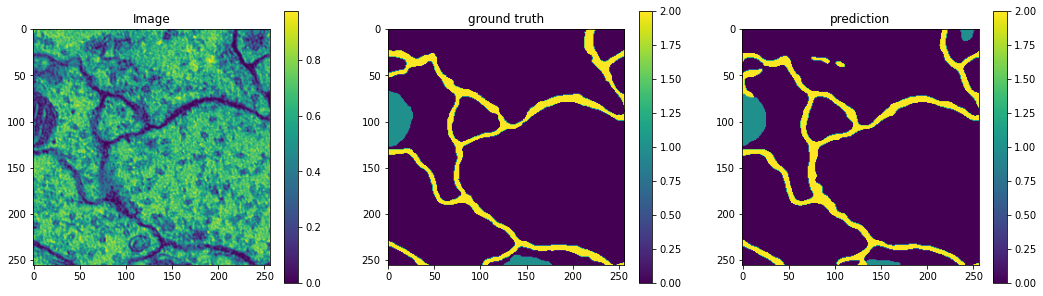

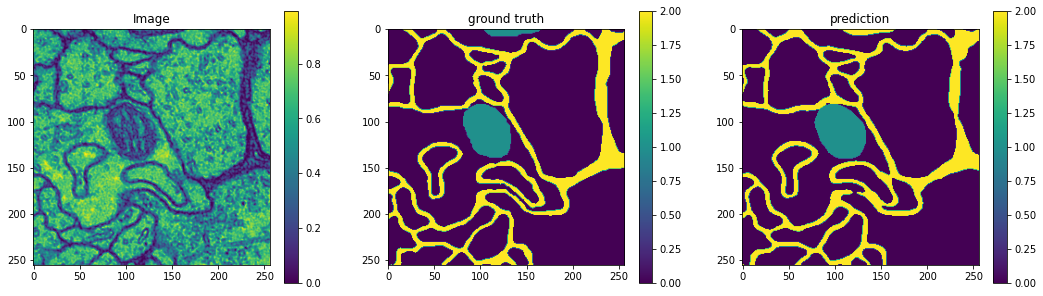

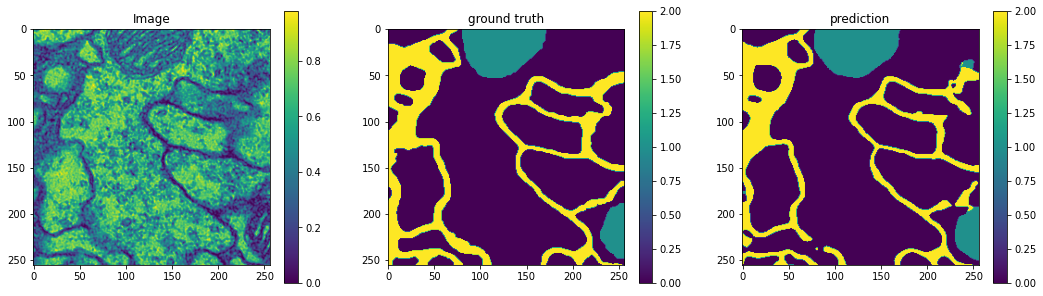

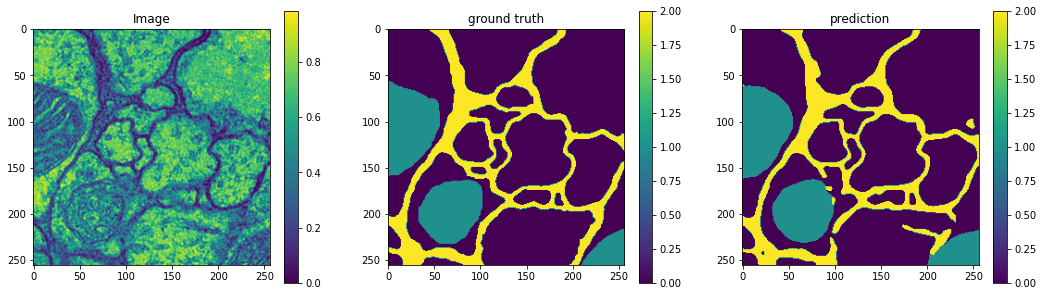

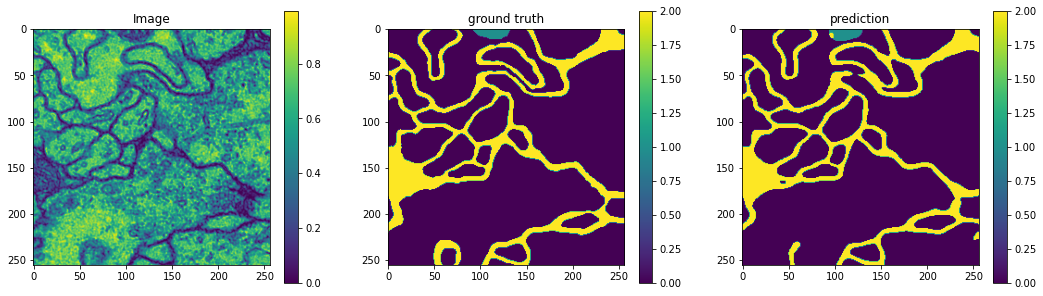

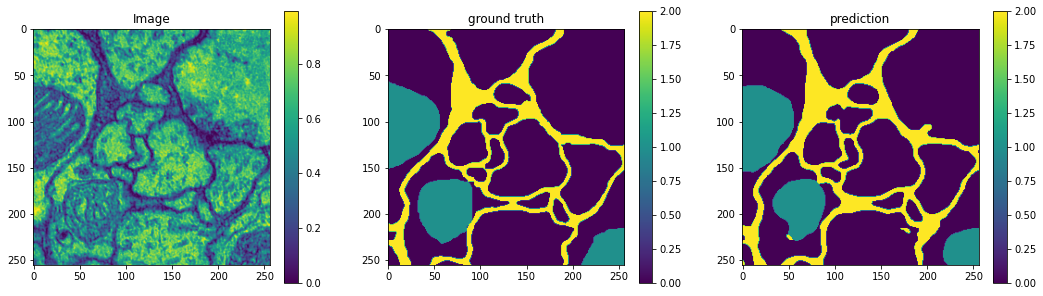

In [63]:
import tensorflow.keras.utils as utils

NUMBER_OF_IMAGES = 8
for _ in range(NUMBER_OF_IMAGES):
    idx = np.random.randint(0, validation_images.shape[0])

    image = validation_images[idx]
    mask = validation_labels[idx]

    prediction = model.predict(image[np.newaxis])[0]
    prediction = np.argmax(prediction, axis=-1)
    
    plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Image")
    plt.colorbar()
    plt.subplot(1, 3, 2)
    plt.imshow(mask)
    plt.title("ground truth")
    plt.colorbar()
    plt.subplot(1, 3, 3)
    plt.imshow(prediction)
    plt.title("prediction")
    plt.colorbar()
    plt.show()